<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/ch6_other_computer_vision_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This chapter covers multi-label classification and regression. The former is for when there are multiple labels per image; the latter for when the labels are numbers.

## Multi-label classification
Using the PASCAL dataset, which can have more than one kind of classified object per image.

In [23]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

The labels in this dataset are contained in a CSV file. Each filename is associated with a space-delimited list of labels.

In [24]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


We can use the `DataBlock` API to get from the pandas dataframe to a `DataLoaders` object. JH suggests starting by putting together a `Dataset` for simplicity as the `DataLoaders` extends on the functionality of the `Datasets`.

In [25]:
dblock = DataBlock() # init empty
dsets = dblock.datasets(df)
dsets.train[0]

(fname       002196.jpg
 labels             cat
 is_valid         False
 Name: 1087, dtype: object,
 fname       002196.jpg
 labels             cat
 is_valid         False
 Name: 1087, dtype: object)

This just returns a row of the pandas dataframe, twice because it assumes input and target but we didn't tell it how to find either specifically.

In [26]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005928.jpg', 'motorbike person')

The book notes that `lambda` functions are useful for experimenting but that we should use the more verbose approch for production as `lambda`s don't work for serialization (?).

It looks like the functions takes the whole pandas dataframe as an argument and returns the correct columns.

Next we need to convert the independent variable to a complete path so we can open it as an image. We also need to convert the dependent variable to a list as there are multiple categories.

In [27]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/djliden91/.fastai/data/pascal_2007/train/008053.jpg'),
 ['bird', 'person'])

Specifying the block types will suffice to conduct the necessary transformation of e.g. images to tensors.

In [28]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x357,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [29]:
dsets.vocab[0:10],dsets.vocab[10:] # HOW DO I PRINT ALL?

((#10) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'],
 (#10) ['diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'])

In [30]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['bicycle','person']

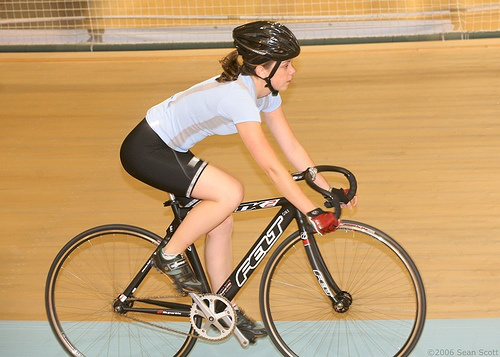

In [31]:
dsets.train[0][0]

So just calling the index directly displays the image. Interesting. Is that a notebook thing or will it work from other interpreter? I'll have to check.

In [32]:
idxs, torch.where(dsets.train[0][1]==1.), dsets.train[0][1]

(tensor([ 1, 14]),
 (tensor([ 1, 14]),),
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

So `torch.where` returns the index of what matches the condition within. What if we invert?

In [33]:
torch.where(dsets.train[0][1]!=1.)

(tensor([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19]),)

By default a tuple is returned. By taking the 0 index, we get the tensor within. Why is that? Another way:

In [34]:
torch.nonzero(dsets.train[0][1], as_tuple=False)

tensor([[ 1],
        [14]])

In [35]:
dsets.train.vocab[torch.nonzero(dsets.train[0][1], as_tuple=False)]

(#2) ['bicycle','person']

Anyway, lots of ways to get at the same thing. Time to move on. The last thing we need to do is tell the `DataBlock` how to split the data. In this case, there is a column in the dataframe, `is_valid`, telling us whether we're dealing with the training or validation sets.

In [36]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

The `~` operator in python is for negation! I did not know this. The last step is to prepare the images for use in the dataloaders by making sure they are all the same size.

In [37]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

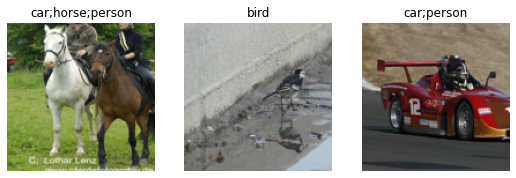

In [38]:
dls.show_batch(nrows=1, ncols=3)

In [39]:
learn = cnn_learner(dls, resnet18)
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

We have this size because the batch size is 64 and we have 20 categories. One activation looks as follows:

In [40]:
activs[0]

tensor([ 0.8468, -0.3104,  0.4383,  1.0432,  0.7935, -1.4948,  2.2737,  0.7011,
        -2.6449,  0.4906,  0.3470, -0.4632, -2.8534,  1.0446, -2.2720,  0.9291,
         0.1513,  3.7515, -0.7005,  3.3482], grad_fn=<SelectBackward>)

Now we define our loss function

In [41]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

With a one-hot encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore `cross_entropy`). This is also a very different situation. We don't really want to make the predictions sum to 1 because the model is looking to identify multiple catetories per images. `nll_loss` returns the value for only one activation, which doesn't work in the multi-class situation.

Of course, `PyTorch` provides its own versions of these functions. These include:
- `F.binary_cross_entropy` and `nn.BCELoss`
- `F.binary_cross_entropy_with_logits` or `nn.BCEWithLogitsLoss`

the latter two (identical) take the sigmoid and then calculate the loss, in a single function.

In [43]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0557, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

fastai will choose this loss function for us by default if we do not choose one manually.

### Choice of metric
We also need to rethink the metric used because this is a multilabel problem. The accuracy metrics we've used before simply ask whether each predicted class matches the target and then gives the proportion of cases for which that is true. The class predicted was the one with the highest activation. But in this case we want to accept all activations exceeding a certain threshold. What threshold? We can set a default and tweak it if necessary.

In [46]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'targ' are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==target.bool()).float().mean()

## Training the Model

In [48]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr =3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/djliden91/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


KeyboardInterrupt: 

*Question*: Why use `partial` here and not just `accuracy_multi(thresh=0.2)`?